In [20]:
# Pandas, NumPy, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# MySQL
import mysql.connector as sql
# Bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from sklearn.preprocessing import MinMaxScaler
output_notebook()

Loading BokehJS ...

## Connect to DB

In [2]:
con = sql.connect(host='localhost', database='secom', user='root', password='1234')

## Load data from table_secom

In [3]:
df_table_secom = pd.read_sql('SELECT * FROM table_secom', con=con)
list_imp_vars = ['v65','v60','v427','v104','v66','v17','v154','v66','v442','v39','v268','v407']
df_table_secom.head()

,id,results,timestamp,v1,v2,v3,v4,v5,v6,v7,...,v577,v578,v583,v584,v585,v586,v587,v588,v589,v590
0,2,1,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,...,2.0952,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
1,3,-1,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,...,1.7585,8.5831,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
2,5,-1,2008-07-19 17:53:00,2946.25,2432.84,2233.3667,1326.5200,1.5334,100.0,100.3967,...,1.6679,13.7755,0.4949,0.0189,0.0044,3.8276,0.0342,0.0151,0.0052,44.0077
3,7,-1,2008-07-19 19:45:00,3058.88,2690.15,2248.9000,1004.4692,0.7884,100.0,106.2400,...,56.4274,16.0862,0.4984,0.0106,0.0034,2.1261,0.0204,0.0194,0.0063,95.0310
4,8,-1,2008-07-19 20:24:00,2967.68,2600.47,2248.9000,1004.4692,0.7884,100.0,106.2400,...,1.3248,14.2892,0.4993,0.0172,0.0046,3.4456,0.0111,0.0124,0.0045,111.6525


## Week analysis

In [4]:
df_weeks = df_table_secom.loc[:,['timestamp','results']]
df_weeks['month'] = df_weeks['timestamp'].dt.month
df_weeks['dayofweek'] = df_weeks['timestamp'].dt.dayofweek
df_week_behavior = df_weeks[['month', 'dayofweek', 'results']].groupby(['month', 'dayofweek']).agg(['count'])
df_week_behavior.columns = ["_".join(x) for x in df_week_behavior.columns.ravel()]
df_week_behavior['perc_total'] = df_week_behavior['results_count']/df_week_behavior['results_count'].sum() * 100
df_week_behavior['count_passed'] = df_weeks[df_weeks['results'] == -1][['month', 'dayofweek', 'results']].groupby(['month', 'dayofweek']).agg(['count'])
df_week_behavior['perc_sel_passed'] = df_week_behavior['count_passed']/df_week_behavior['results_count'] * 100
df_week_behavior['count_failed'] = df_weeks[df_weeks['results'] == 1][['month', 'dayofweek', 'results']].groupby(['month', 'dayofweek']).agg(['count'])
df_week_behavior['perc_sel_failed'] = df_week_behavior['count_failed']/df_week_behavior['results_count'] * 100


In [5]:
df_week_behavior.sort_values(['perc_sel_failed'], ascending=False).head()
df_week_behavior = df_week_behavior.reset_index()
df_week_behavior['month_dayofweek'] = df_week_behavior['month'].map(str)  + '-' + df_week_behavior['dayofweek'].map(str)
df_week_behavior.head()

,month,dayofweek,results_count,perc_total,count_passed,perc_sel_passed,count_failed,perc_sel_failed,month_dayofweek
0,1,1,6,0.496278,6.0,100.000000,NaN,NaN,1-1
1,1,2,14,1.157982,14.0,100.000000,NaN,NaN,1-2
2,1,3,15,1.240695,14.0,93.333333,1.0,6.666667,1-3
3,2,4,1,0.082713,1.0,100.000000,NaN,NaN,2-4
4,2,5,30,2.481390,30.0,100.000000,NaN,NaN,2-5


In [6]:
df_week_var = df_table_secom.loc[:,list_imp_vars]
scaler = MinMaxScaler()
df_week_var_scaled = pd.DataFrame(scaler.fit_transform(df_week_var), columns=df_week_var.columns)
df_week_var_scaled['month'] = df_table_secom.loc[:,['timestamp']]['timestamp'].dt.month
df_week_var_scaled['dayofweek'] = df_table_secom.loc[:,['timestamp']]['timestamp'].dt.dayofweek

In [7]:
df_week_var = pd.melt(df_week_var_scaled.reset_index(), id_vars=['month','dayofweek'], value_vars=list_imp_vars, var_name='variable', value_name='value')
df_week_var['month_dayofweek'] = df_week_var['month'].map(str)  + '-' + df_week_var['dayofweek'].map(str)
df_week_var.head()

,month,dayofweek,variable,value,month_dayofweek
0,7,5,v65,0.232352,7-5
1,7,5,v65,0.219104,7-5
2,7,5,v65,0.125555,7-5
3,7,5,v65,0.105600,7-5
4,7,5,v65,0.156999,7-5


In [8]:
df_week_description = df_week_var.groupby(['month_dayofweek','variable'])['month_dayofweek','value'].describe()
df_week_description.columns = df_week_description.columns.droplevel(0)
df_week_description = df_week_description.reset_index()
df_week_description = pd.merge(df_week_description, df_week_behavior,  how='left', left_on=['month_dayofweek'], right_on=['month_dayofweek'])
df_week_description = df_week_description.sort_values(['month_dayofweek'])
df_week_description.head()

,month_dayofweek,variable,count,mean,std,min,25%,50%,75%,max,month,dayofweek,results_count,perc_total,count_passed,perc_sel_passed,count_failed,perc_sel_failed
0,1-1,v104,6.0,0.486505,0.032228,0.449393,0.465587,0.477733,0.511134,0.530364,1,1,6,0.496278,6.0,100.0,NaN,NaN
1,1-1,v154,6.0,0.041436,0.019300,0.017000,0.026987,0.043349,0.056524,0.062473,1,1,6,0.496278,6.0,100.0,NaN,NaN
2,1-1,v17,6.0,0.588294,0.040514,0.529513,0.565261,0.589498,0.619079,0.635134,1,1,6,0.496278,6.0,100.0,NaN,NaN
3,1-1,v268,6.0,0.150966,0.213591,0.063768,0.063768,0.063768,0.063768,0.586957,1,1,6,0.496278,6.0,100.0,NaN,NaN
4,1-1,v39,6.0,0.765439,0.205300,0.542525,0.584730,0.784542,0.945593,0.963620,1,1,6,0.496278,6.0,100.0,NaN,NaN


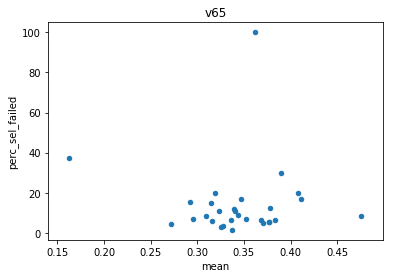

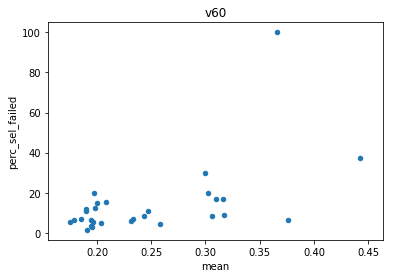

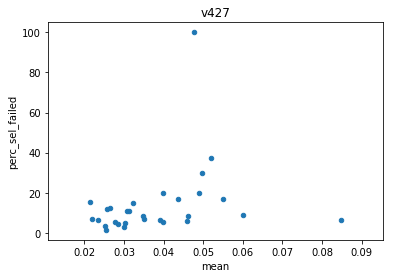

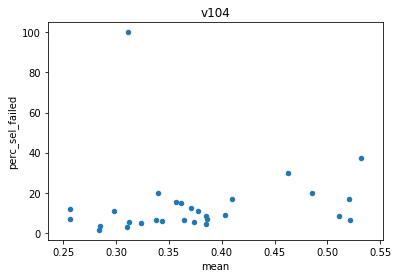

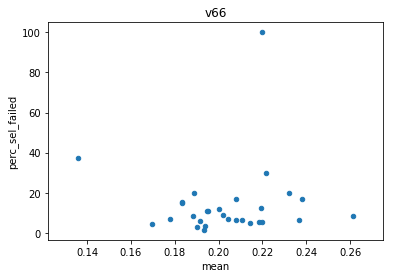

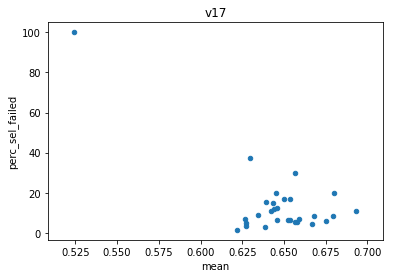

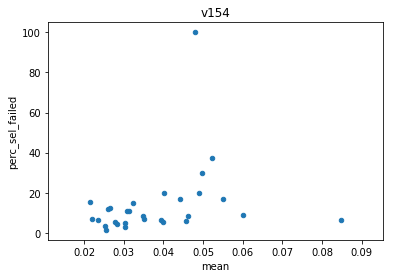

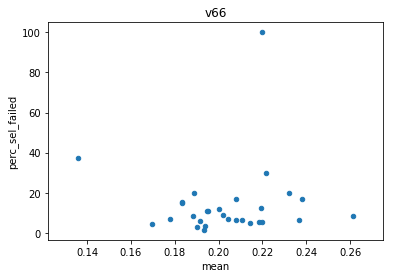

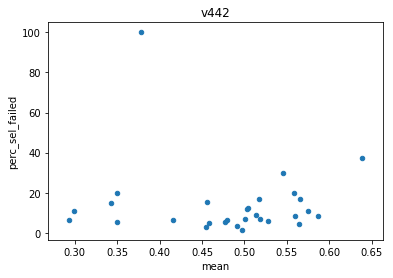

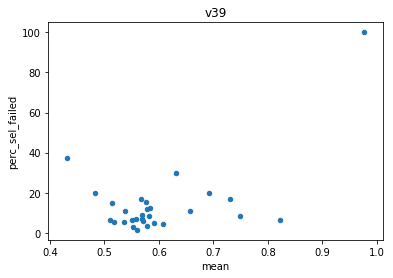

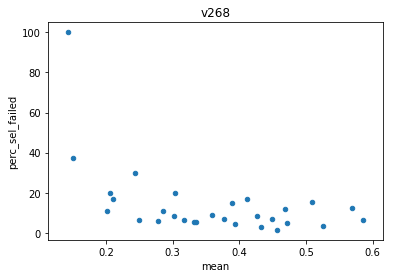

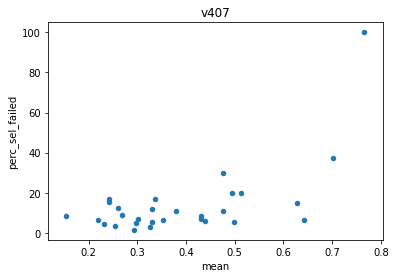

In [9]:
for i,var in enumerate(list_imp_vars):
    df_week_description[df_week_description['variable'] == var].plot(kind='scatter', x='mean', y='perc_sel_failed', title=var);
plt.show()

In [10]:
df_week_description[(df_week_description['variable'] == 'v65') & (df_week_description['perc_sel_failed'] == 100.0)]
#df_week_description.sort_values('perc_sel_failed', ascending=False)['perc_sel_failed']

,month_dayofweek,variable,count,mean,std,min,25%,50%,75%,max,month,dayofweek,results_count,perc_total,count_passed,perc_sel_passed,count_failed,perc_sel_failed
361,7-4,v65,1.0,0.362078,NaN,0.362078,0.362078,0.362078,0.362078,0.362078,7,4,1,0.082713,NaN,NaN,1.0,100.0


## Month Analysis

In [11]:
df_months = df_table_secom.loc[:,['timestamp','results']]
df_months['month'] = df_weeks['timestamp'].dt.month
df_months_behavior = df_weeks[['month','results']].groupby(['month']).agg(['count'])
df_months_behavior.columns = ["_".join(x) for x in df_months_behavior.columns.ravel()]
df_months_behavior['count_passed'] = df_months[df_months['results'] == -1][['month', 'results']].groupby(['month']).agg(['count'])
df_months_behavior['count_failed'] = df_months[df_months['results'] == 1][['month', 'results']].groupby(['month']).agg(['count'])
df_months_behavior['perc_sel_passed'] = df_months_behavior['count_passed']/df_months_behavior['results_count'] * 100
df_months_behavior['perc_sel_failed'] = df_months_behavior['count_failed']/df_months_behavior['results_count'] * 100

In [12]:
df_months_behavior.sort_values(['perc_sel_failed'], ascending=False)
df_months_behavior = df_months_behavior.reset_index()

In [13]:
df_month_var = df_table_secom.loc[:,list_imp_vars]
scaler = MinMaxScaler()
df_month_var_scaled = pd.DataFrame(scaler.fit_transform(df_month_var), columns=df_month_var.columns)
df_month_var_scaled['month'] = df_table_secom.loc[:,['timestamp']]['timestamp'].dt.month

In [14]:
df_month_var = pd.melt(df_month_var_scaled.reset_index(), id_vars=['month'], value_vars=list_imp_vars, var_name='variable', value_name='value')

In [15]:
df_month_description = df_month_var.groupby(['month','variable']).describe()
df_month_description.columns = df_month_description.columns.droplevel(0)
df_month_description = df_month_description.reset_index()
df_month_description = pd.merge(df_month_description, df_months_behavior,  how='left', left_on=['month'], right_on=['month'])
df_month_description = df_month_description.sort_values(['month'])
df_month_description.head()

,month,variable,count,mean,std,min,25%,50%,75%,max,results_count,count_passed,count_failed,perc_sel_passed,perc_sel_failed
0,1,v104,35.0,0.386119,0.080859,0.202429,0.350202,0.376518,0.437247,0.538462,35,34,1.0,97.142857,2.857143
1,1,v154,35.0,0.057337,0.165355,0.003400,0.016362,0.025924,0.042711,1.000000,35,34,1.0,97.142857,2.857143
2,1,v17,35.0,0.625112,0.055082,0.509694,0.594333,0.620258,0.654078,0.733354,35,34,1.0,97.142857,2.857143
3,1,v268,35.0,0.197246,0.204538,0.054348,0.063768,0.081884,0.308696,0.722464,35,34,1.0,97.142857,2.857143
4,1,v39,35.0,0.567411,0.132327,0.405578,0.485052,0.542525,0.595209,0.963620,35,34,1.0,97.142857,2.857143


In [23]:
plt_month_mean = figure(width=900, x_axis_label='Month', y_axis_label='Feature mean') 
color = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']
x_values = df_month_description['month'].unique()
for i, var in enumerate(list_imp_vars):
    y_values = list(df_month_description[df_month_description['variable'] == var]['mean'])
    plt_month_mean.line(x_values, y_values, legend=var, line_width=2, color=color[i])
show(plt_month_mean)


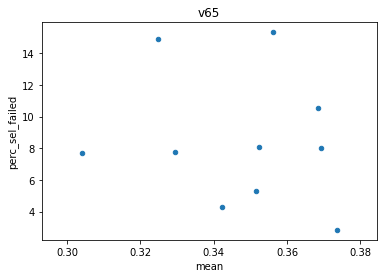

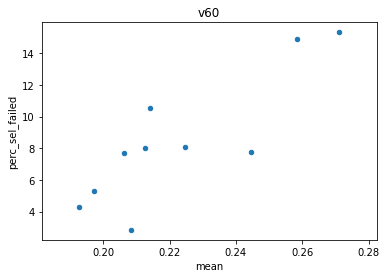

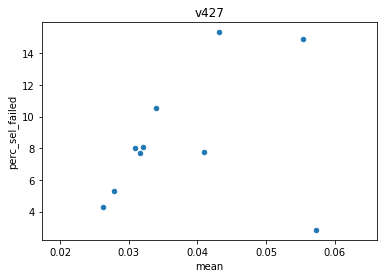

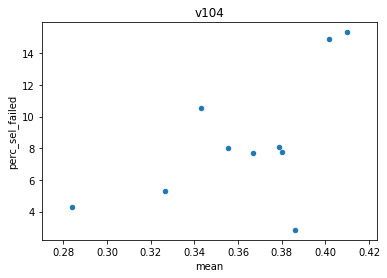

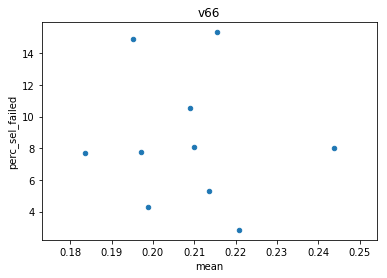

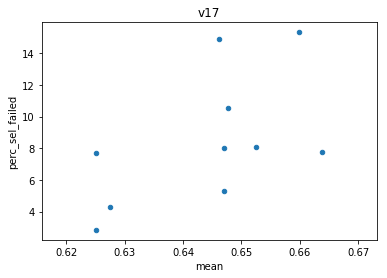

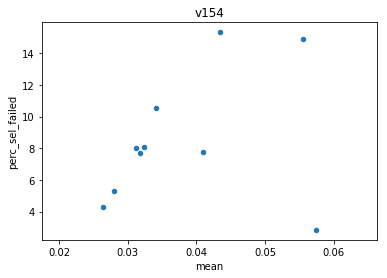

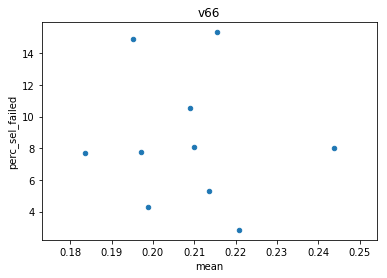

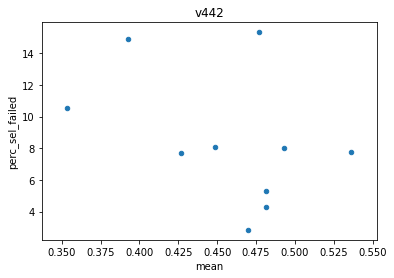

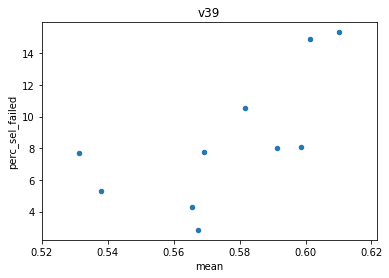

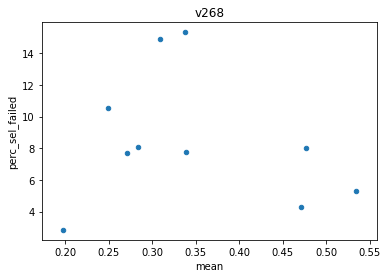

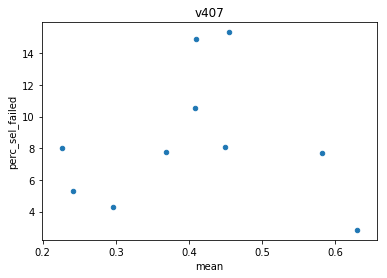

In [17]:
for i,var in enumerate(list_imp_vars):
    df_month_description[df_month_description['variable'] == var].plot(kind='scatter', x='mean', y='perc_sel_failed', title=var);
plt.show()